In [1]:
import argparse
import sys
import shap
import numpy as np
from transformers import AutoTokenizer

In [2]:
def main(args, sampler, scorer):
    scorer.set_aggregate(args['aggregate'])
    # explainer = shap.Explainer(scorer.get_scores, scorer.get_masker(), output_names=scorer.get_categories())
    if args['randomize_data']:
        sampler.randomize()
    conv_to_explain = []
    background_data = []
    explain_flag = True
    for i, conversation in enumerate(sampler.get_next()):
        if explain_flag:
            conv_to_explain.append(conversation)
        background_data.append(conversation)
        if not args['all'] and (i + 1) == args['num_examples']:
            explain_flag = False
    # print(len(scorer._tokenizer(conv_to_explain[0])['input_ids']))
    print(f'Number of conversation: {len(conv_to_explain)}')
    # print(background_data)
    formatted_conversations = np.array(scorer.format_conversations(conv_to_explain)).reshape((len(conv_to_explain), -1))
    bgd_formatted_conversations = np.array(scorer.format_conversations(background_data)).reshape((len(background_data), -1))

    explainer = shap.KernelExplainer(scorer.get_scores, (bgd_formatted_conversations[10:20], scorer._tokenizer), special_token=220)
    # explainer = shap.KernelExplainer(scorer.get_scores, (bgd_formatted_conversations[10:20], scorer._tokenizer), special_token=220)
    # return explainer.shap_values(np.array([scorer._tokenizer.tokenize(formatted_conversations[0])]))
    print('input shape:', formatted_conversations.shape)
    return explainer.shap_values(formatted_conversations, nsamples=args['n_samples'])

In [3]:
args = {'sampler_path' : '/home/ubuntu/fed/', \
        'scorer_path' : '/home/ubuntu/fed/', \
        'randomize_data': False, \
        'all' : False, \
        'num_examples' : 1, \
        'e' : 'vocab', \
        'top_k' : 1, \
        'aggregate' : False, \
        'n_samples' : 500}

In [4]:
sys.path.insert(0, args['scorer_path'])
if args['sampler_path'] != args['scorer_path']:
    sys.path.insert(0, args['sampler_path'])

In [5]:

from sample import conversation_sampler
from score import conversation_scorer
from score import DialoGPTMetric

sampler = conversation_sampler()
scorer = conversation_scorer()
# scorer = DialoGPTMetric()
# scorer.to('cuda')
# scorer.eval()

Number of candidate conversations: 41
The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.


In [6]:
# scorer(['my name is baber'])

In [9]:
shap_values = main(args, sampler, scorer)
print(shap_values.shape)

Number of conversation: 1
Number of conversations: 10
The input conversations: ["Hi! <|endoftext|> Hi! Sorry for the late response. How are you doing? <|endoftext|> I'm great, thanks! I'm meeting some friends for a soccer game soon. What about you? <|endoftext|> I just got a matcha latte <|endoftext|> Yes, but I'm terrible at it. It's fun to play anything with friends, I think. Would you prefer to exercise with a group, or by yourself, do you think? <|endoftext|> I think playing a team sport would be fun if it's casual but I primarily run by myself if I exercise. I also got the Ring Fit adventure game on the switch recently. It's basically a game-ified way to exercise <|endoftext|> I'm thinking about getting a Switch, would you recommend it? <|endoftext|> Yes! There are a lot of really great games on the Switch. Two of my favorites are Octopath Traveler and Fire Emblem. Do you play a lot of video games? <|endoftext|> I'm not much of a gamer but it's something I'd like to get into. <|en

Number of conversations: 1
The input conversations: ["Hi! <|endoftext|> Hey <|endoftext|> How's your day going? <|endoftext|> pretty good. yours? <|endoftext|> Ehh it's fine. I didn't do so well on that history test, actually.. <|endoftext|> oh what happened? <|endoftext|> Apparently Christopher Columbus didn't fight in the Civil War <|endoftext|> hahah wait for real? <|endoftext|> I know right! Are you taking History next semester? <|endoftext|> No I'm not in school anymore <|endoftext|> Oh I see. What do you do? <|endoftext|> I train and compete in horse vaulting <|endoftext|> Oh wow. Were you born a horse, or were you turned into one? <|endoftext|> lol you're too funny <|endoftext|> Just kidding. That sounds pretty cool! Is it your job? <|endoftext|> Yeah, but I part time work on a farm. Helping with a bit of everything <|endoftext|> Wow, sounds very busy! Do you win money at those horse vaulting competitions?"]
Number of conversations: 500
The input conversations: ['<|endoftext|><|

User: Hi!
System: Hey
User: How's your day going?
System: pretty good. yours?
User: Ehh it's fine. I didn't do so well on that history test, actually..
System: oh what happened?
User: Apparently Christopher Columbus didn't fight in the Civil War :')
System: hahah wait for real?
User: I know right! Are you taking History next semester?
System: No I'm not in school anymore
User: Oh I see. What do you do?
System: I train and compete in horse vaulting
User: Oh wow. Were you born a horse, or were you turned into one?
System: lol you're too funny
User: Just kidding. That sounds pretty cool! Is it your job?
System: Yeah, but I part time work on a farm. Helping with a bit of everything
User: Wow, sounds very busy! Do you win money at those horse vaulting competitions?


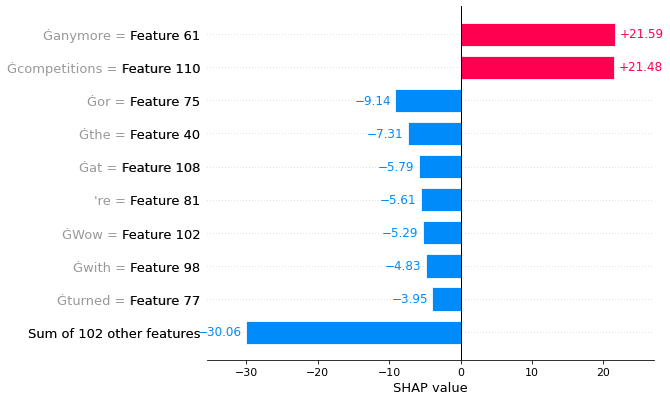

In [35]:
# ['interesting', 'engaging', 'specific', 'relevant', 'correct', \
#                 'semantically appropriate', 'understandable', 'fluent', 'coherent', 'error recovery', \
#                 'consistent', 'diverse', 'depth', 'likeable', 'understand', 'flexible', 'informative', 'inquisitive']
# shap_values[:, :, 0].mean(0).shape
# shap.initjs()
# shap.plots.bar(shap_values[:, :, 0].mean(0), max_display=10)
# shap_values[0, :250]
print(next(sampler.get_next()))
scores = dict()
conv_tokens = scorer._tokenizer.tokenize(scorer.format_conversations([next(sampler.get_next())])[0])
for i, token in enumerate(conv_tokens):
    scores.setdefault(token, (0, 0))
    scores[token] = (scores[token][0] + shap_values[0][i], scores[token][1] + 1)
scores
expl_obj = shap.Explanation([scores[k][0]/scores[k][1] for k in scores.keys()], data=list(scores.keys()))
shap.plots.bar(expl_obj)

In [ ]:
property_under_consideration = 'understand'
np.mean(shap_values[:, :, property_under_consideration].mean(0).values), \
    np.std(shap_values[:, :, property_under_consideration].mean(0).values)

In [33]:
import pickle

In [34]:
# pickle.dump(shap_values, open('kernelshap_values.pkl', 'wb'))

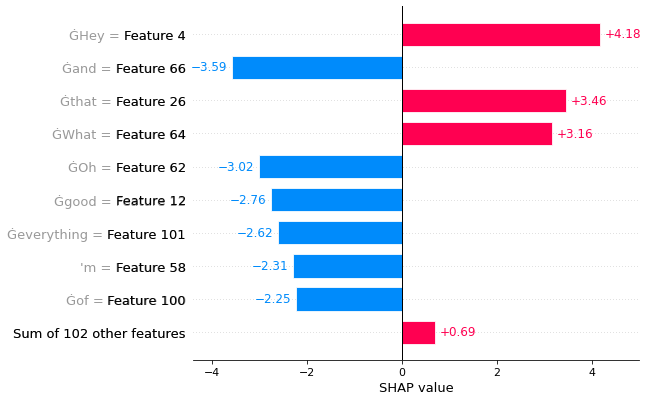

In [8]:
# ['interesting', 'engaging', 'specific', 'relevant', 'correct', \
#                 'semantically appropriate', 'understandable', 'fluent', 'coherent', 'error recovery', \
#                 'consistent', 'diverse', 'depth', 'likeable', 'understand', 'flexible', 'informative', 'inquisitive']
# shap_values[:, :, 0].mean(0).shape
# shap.initjs()
# shap.plots.bar(shap_values[:, :, 0].mean(0), max_display=10)
# shap_values[0, :250]
# print(next(sampler.get_next()))
scores = dict()
conv_tokens = scorer._tokenizer.tokenize(scorer.format_conversations([next(sampler.get_next())])[0])
for i, token in enumerate(conv_tokens):
    scores.setdefault(token, (0, 0))
    scores[token] = (scores[token][0] + shap_values[0][i], scores[token][1] + 1)
scores
expl_obj = shap.Explanation([scores[k][0]/scores[k][1] for k in scores.keys()], data=list(scores.keys()))
shap.plots.bar(expl_obj)

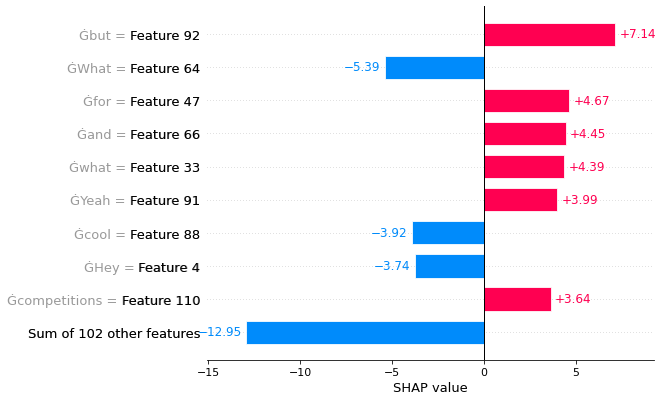

In [10]:
# ['interesting', 'engaging', 'specific', 'relevant', 'correct', \
#                 'semantically appropriate', 'understandable', 'fluent', 'coherent', 'error recovery', \
#                 'consistent', 'diverse', 'depth', 'likeable', 'understand', 'flexible', 'informative', 'inquisitive']
# shap_values[:, :, 0].mean(0).shape
# shap.initjs()
# shap.plots.bar(shap_values[:, :, 0].mean(0), max_display=10)
# shap_values[0, :250]
# print(next(sampler.get_next()))
scores = dict()
conv_tokens = scorer._tokenizer.tokenize(scorer.format_conversations([next(sampler.get_next())])[0])
for i, token in enumerate(conv_tokens):
    scores.setdefault(token, (0, 0))
    scores[token] = (scores[token][0] + shap_values[0][i], scores[token][1] + 1)
scores
expl_obj = shap.Explanation([scores[k][0]/scores[k][1] for k in scores.keys()], data=list(scores.keys()))
shap.plots.bar(expl_obj)

In [ ]:
"Hi! <|endoftext|> Hey <|endoftext|> How's your day going? <|endoftext|> pretty good. yours? <|endoftext|> Ehh it's fine. I didn't do so well on that history test, actually.. <|endoftext|> oh what happened? <|endoftext|> Apparently Christopher Columbus didn't fight in the Civil War <|endoftext|> hahah wait for real? <|endoftext|> I know right! Are you taking History next semester? <|endoftext|> No I'm not in school anymore <|endoftext|> Oh I see. What do you do? <|endoftext|> I train and compete in horse vaulting <|endoftext|> Oh wow. Were you born a horse, or were you turned into one? <|endoftext|> lol you're too funny <|endoftext|> Just kidding. That sounds pretty cool! Is it your job? <|endoftext|> Yeah, but I part time work on a farm. Helping with a bit of everything <|endoftext|> Wow, sounds very busy! Do you win money at those horse vaulting competitions?"